In [48]:
import os
import sys

model_path = "/Users/neda/HiCPlus_pytorch/src/models"
sys.path.insert(0, model_path)
import model

import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
from torch.utils import data
import torch
import torch.optim as optim
from torch.autograd import Variable
from time import gmtime, strftime
import torch.nn as nn
from scipy.stats.stats import pearsonr
import argparse
use_gpu = 0
down_sample_ratio = 16
epochs = 30
HiC_max_value = 100 # ?????
batch_size = 256

def corr_highVSlow(index,data1,data2):
    return pearsonr(data1[index,0,:,:].flatten(),data2[index,0,:,:].flatten())[0]

In [53]:
indices = np.load("/Users/neda/HiCPlus_pytorch/data/divided-data/GM12878_primary/10kb_resolution/chr1-17-index.npy", "r")
indices = indices[:,1:4].astype("int64")

In [50]:
def d_indices(d):
    return np.where(indices[:,1] + d == indices[:,2])

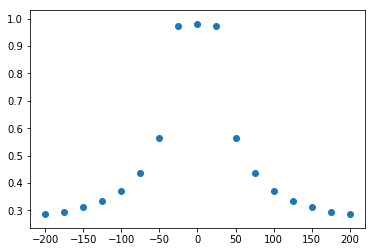

In [103]:
# mean of correlation based on location of frames responding to diagonal of matrix
mean_int = {}
for i in range(-200,201,25):
    mean_int[i] = []
    for j in d_indices(i)[0]:
        mean_int[i].append(np.mean(low_resolution_samples[j,]))  
corr_list = {}
for i in range(-200,201,25):
    corr_list[i] = []
    for j in d_indices(i)[0]:
        if np.sum(low_resolution_samples[j,:,:]) != 0 and np.sum(high_resolution_samples[j,:,:]) != 0:
            corr_list[i].append(pearsonr(low_resolution_samples[j,0,:,:].flatten(),high_resolution_samples[j,0,:,:].flatten())[0]) 
mean_corr_list = [np.mean(corr_list[i]) for i in range(-200,201,25)]
import matplotlib.pyplot as plt
plt.scatter(range(-200,201,25), mean_corr_list)
plt.show()

In [41]:
# defining network

Net = model.Net(40, 28)
if use_gpu:
    Net = Net.cuda()

optimizer = optim.SGD(Net.parameters(), lr = 0.00001)
_loss = nn.MSELoss()
Net.train()

running_loss = 0.0
losslist = []

In [56]:
# defining training data

low_resolution_samples = np.load("/Users/neda/HiCPlus_pytorch/data/divided-data/GM12878_primary/10kb_resolution/chr1-17(down16).npy", "r").astype(np.float32) * down_sample_ratio
low_resolution_samples = np.expand_dims(low_resolution_samples, axis=1)
high_resolution_samples = np.load("/Users/neda/HiCPlus_pytorch/data/divided-data/GM12878_primary/10kb_resolution/chr1-17.npy", "r").astype(np.float32)
high_resolution_samples = np.expand_dims(high_resolution_samples, axis=1)
#high_resolution_samples = high_resolution_samples[d_indices(50)[0],:,:,:]
#low_resolution_samples = low_resolution_samples[d_indices(50)[0],:,:,:]
sample_size = high_resolution_samples.shape[-1]
half_padding = int(model.half_padding)
high_resolution_samples = np.minimum(high_resolution_samples, HiC_max_value)
low_resolution_samples = np.minimum(low_resolution_samples, HiC_max_value)
high_resolution_samples = high_resolution_samples[:,:,half_padding:(sample_size-half_padding),half_padding:(sample_size-half_padding)]
lowres_set = data.TensorDataset(torch.from_numpy(low_resolution_samples), torch.from_numpy(np.zeros(low_resolution_samples.shape[0])))
lowres_loader = torch.utils.data.DataLoader(lowres_set, batch_size=batch_size, shuffle=False)

hires_set = data.TensorDataset(torch.from_numpy(high_resolution_samples), torch.from_numpy(np.zeros(high_resolution_samples.shape[0])))
hires_loader = torch.utils.data.DataLoader(hires_set, batch_size=batch_size, shuffle=False)

In [ ]:


for epoch in range(0, epochs):
    # iterate over two lists and their indices using enumerate together with zip
    # lowres_loader is list of batches
    for i, (v1, v2) in enumerate(zip(lowres_loader, hires_loader)):
        # probably it is for skipping last incomplete batch
        if (i == len(lowres_loader) - 1):
            continue


        # v1 is list with length = 2. v1[0] is data tensor so with shape 256*1*40*40. v1[1] is vector of 256 zeros because pf line 85 but what's the reason?
        _lowRes, _ = v1
        _highRes, _ = v2
        # print "_lowres:", _lowRes, "\n shape: ", _lowRes.shape

        _lowRes = Variable(_lowRes)
        _highRes = Variable(_highRes)


        if use_gpu:
            _lowRes = _lowRes.cuda()
            _highRes = _highRes.cuda()
        optimizer.zero_grad()
        y_prediction = Net(_lowRes)
        loss = _loss(y_prediction, _highRes)
        loss.backward()
        optimizer.step()
        #print(loss.item())
        running_loss += loss.item()

    print ('-------', i, epoch, running_loss/i, strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    losslist.append(running_loss/i)
    running_loss = 0.0

------- 679 0 833.4726020390927 2019-06-28 17:54:46
------- 679 1 642.8925025765078 2019-06-28 17:55:27
------- 679 2 642.8925025765078 2019-06-28 17:56:08
------- 679 3 642.8925025765078 2019-06-28 17:56:51
------- 679 4 642.8925025765078 2019-06-28 17:57:32
------- 679 5 642.8925025765078 2019-06-28 17:58:15
------- 679 6 642.8925025765078 2019-06-28 17:59:12
------- 679 7 642.8925025765078 2019-06-28 18:00:14
